# IMPORTS

In [4]:
import pandas as pd
import numpy as np
import re

import openpyxl

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as ticker
import seaborn as sns
import sklearn
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, cross_validate, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.tree import export_graphviz

import graphviz


from IPython.display import display
import pickle
random_state = 1
matplotlib.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['font.size'] = 10

pd.set_option('display.max_rows', 5)
pd.set_option('display.max_columns', None)

# FUNCTIONS

In [5]:
#---------------------------------------------------------------------------------------------#
# FUNCTION TO PROCESS THE INITIAL DATAFRAME AND ADD THE CORRECT HEADERS:

def process_dataframe(input_df):
    # Create a copy of the input DataFrame to avoid modifying the original
    processed_df = input_df.copy()
    
    # Initialize a list to store the new column names
    new_columns = []

    # Iterate through the elements of the first and second rows of the DataFrame in parallel
    for col1, col2 in zip(processed_df.iloc[0], processed_df.iloc[1]):
        # Check if the value in the first row is NaN
        if pd.isna(col1):
            # If it's NaN, use the value from the second row as the new column name
            new_columns.append(col2)
        else:
            # If it's not NaN, combine the values from the first and second rows with an underscore
            new_columns.append(f"{col1}_{col2}")

    # Update the column names of the processed DataFrame with the new names
    processed_df.columns = new_columns
    
    # Remove the first and second rows from the DataFrame since they are now used as column names
    processed_df.drop([0, 1], inplace=True)  

    # Reset the index of the DataFrame for consistency
    processed_df.reset_index(drop=True, inplace=True)

    # Return the processed DataFrame with updated column names
    return processed_df

#---------------------------------------------------------------------------------------------#
# FUNCTION TO NORMALIZE THE DATAFRAME AND DELETE COLUMNS WITH LOW VARIANCE: 

def normalize_dataframe(dataframe, variance_threshold=0.0):
    normalized_df = dataframe.copy()
    columns_to_normalize = dataframe.columns[prop_start_index:]
    scaler = MinMaxScaler()
    normalized_df[columns_to_normalize] = scaler.fit_transform(dataframe[columns_to_normalize])
    
    selector = VarianceThreshold(threshold=variance_threshold)
    selected_columns = selector.fit_transform(normalized_df[columns_to_normalize])
    normalized_df = normalized_df.iloc[:, :prop_start_index].join(pd.DataFrame(selected_columns, columns=columns_to_normalize[selector.get_support()]))
    
    return normalized_df

#---------------------------------------------------------------------------------------------#
def correlated_pairs(dataframe, threshold=0.95):
    df_corr = dataframe.corr().abs()
    upper = df_corr.where(np.triu(np.ones(df_corr.shape), k=1).astype(bool))
    correlated_pairs = []
    for col1 in upper.columns:
        for col2 in upper.columns:
            if col1 != col2 and upper[col1][col2] > threshold:
                correlated_pairs.append((col1, col2))
    if correlated_pairs:
        print(f"Highly correlated column pairs with a correlation coefficient above {threshold}:")
        for col1, col2 in correlated_pairs:
            print(f"Correlated Pair: {col1} : {col2}")
    else:
        print("No highly correlated column pairs found.")

    return None

#---------------------------------------------------------------------------------------------#
def drop_columns(dataframe, substrings):
    columns_to_drop = [col for col in dataframe.columns if any(substring in col for substring in substrings)]
    return dataframe.drop(columns=columns_to_drop)

# LOADING DATASET

In [6]:
# Change excel file name and sheet: 

excel = "data_example"
expt_sheet = "Sheet1"

###############
load_df = pd.read_excel(excel + ".xlsx", expt_sheet, header=None, engine='openpyxl')

initial_df = process_dataframe(load_df)

prop_start = next((col for col in initial_df.columns if col.startswith("x1_")), None)
prop_start_index = initial_df.columns.get_loc(prop_start)
display(initial_df)

,ID,SMILES,ligand,sf_mp_average,n to c ratio,E,ES_root_dipole,ES_root_electronic_spatial_extent,ES_root_molar_volume,E_scf,E_thermal_correction,E_zpe,G,G_thermal_correction,H,H_thermal_correction,x1_charge,x2_dipole,x3_electronegativity,x4_electronic_spatial_extent,x5_hardness,x6_homo_energy,x7_lumo_energy,x8_molar_mass,x9_molar_volume,x10_multiplicity,x11_number_of_atoms,x12_zero_point_correction,x13_min_APT_charge,x14_min_ES_root_Mulliken_charge,x15_min_ES_root_NPA_Rydberg,x16_min_ES_root_NPA_charge,x17_min_ES_root_NPA_core,x18_min_ES_root_NPA_total,x19_min_ES_root_NPA_valence,x20_min_Mulliken_charge,x21_min_NMR_anisotropy,x22_min_NMR_shift,x23_min_NPA_Rydberg,x24_min_NPA_charge,x25_min_NPA_core,x26_min_NPA_total,x27_min_NPA_valence,x28_min_VBur,x29_max_APT_charge,x30_max_ES_root_Mulliken_charge,x31_max_ES_root_NPA_Rydberg,x32_max_ES_root_NPA_charge,x33_max_ES_root_NPA_core,x34_max_ES_root_NPA_total,x35_max_ES_root_NPA_valence,x36_max_Mulliken_charge,x37_max_NMR_anisotropy,x38_max_NMR_shift,x39_max_NPA_Rydberg,x40_max_NPA_charge,x41_max_NPA_core,x42_max_NPA_total,x43_max_NPA_valence,x44_max_VBur,x45_S_APT_charge,x46_S_ES_root_Mulliken_charge,x47_S_ES_root_NPA_Rydberg,x48_S_ES_root_NPA_charge,x49_S_ES_root_NPA_core,x50_S_ES_root_NPA_total,x51_S_ES_root_NPA_valence,x52_S_Mulliken_charge,x53_S_NMR_anisotropy,x54_S_NMR_shift,x55_S_NPA_Rydberg,x56_S_NPA_charge,x57_S_NPA_core,x58_S_NPA_total,x59_S_NPA_valence,x60_S_VBur,x61_C_APT_charge,x62_C_ES_root_Mulliken_charge,x63_C_ES_root_NPA_Rydberg,x64_C_ES_root_NPA_charge,x65_C_ES_root_NPA_core,x66_C_ES_root_NPA_total,x67_C_ES_root_NPA_valence,x68_C_Mulliken_charge,x69_C_NMR_anisotropy,x70_C_NMR_shift,x71_C_NPA_Rydberg,x72_C_NPA_charge,x73_C_NPA_core,x74_C_NPA_total,x75_C_NPA_valence,x76_C_VBur,x77_Unnamed: 89,x78_#stars,x79_#amine,x80_#amidine,x81_#acid,x82_#amide,x83_#rotor,x84_#rtvFG,x85_CNS,x86_mol MW,x87_dipole.1,x88_SASA,x89_FOSA,x90_FISA,x91_PISA,x92_WPSA,x93_volume,x94_donorHB,x95_accptHB,x96_dip^2/V,x97_ACxDN^.5/SA,x98_glob,x99_QPpolrz,x100_QPlogPC16,x101_QPlogPoct,x102_QPlogPw,x103_QPlogPo/w,x104_QPlogS,x105_CIQPlogS,x106_QPlogHERG,x107_QPPCaco,x108_QPlogBB,x109_QPPMDCK,x110_QPlogKp,x111_IP(eV),x112_EA(eV),x113_#metab,x114_QPlogKhsa,x115_HumanOralAbsorption,x116_PercentHumanOralAbsorption,x117_SAfluorine,x118_SAamideO,x119_PSA,x120_#NandO,x121_RuleOfFive,x122_RuleOfThree,x123_#ringatoms,x124_#in34,x125_#in56,x126_#noncon,x127_#nonHatm,x128_Jm
0,7,O=S(=O)(F)c1cccc(S(=O)(=O)Cl)c1,"InChI=1S/C6H4ClFO4S2/c7-13(9,10)5-2-1-3-6(4-5)...",28,0,-1048.887537,8.9665,4780.9432,2032.706,-1049.158052,0.279652,-1048.904105,-1048.948225,0.218964,-1048.886593,0.280597,0,3.9313,0.12354,4829.5233,0.08783,-0.21137,-0.03571,236.3312,1916.552,1,32,0.263084,-0.90191,-0.641041,0.00063,-0.7091,0,0.495,0.49169,-0.648399,5.6271,21.4827,0.00067,-0.72499,0,0.48205,0.4778,0.315057,0.967822,0.467865,0.03879,0.51139,9.99919,15.84372,6.69353,0.475899,394.515,533.2811,0.03998,0.60331,9.99926,15.96332,6.71387,0.734031,-0.190453,0.088789,0.03879,0.15628,9.99919,15.84372,5.80574,-0.009906,394.515,533.2811,0.03998,0.03668,9.99926,15.96332,5.92408,0.39325,0.366234,-0.10473,0.01728,-0.16807,1.99875,6.16807,4.15204,-0.099934,140.8627,65.2444,0.01727,-0.18917,1.99877,6.18917,4.17314,0.614616,NaN,1,0,0,0,0,2,2,1,208.677,6.021,373.762,0,82.397,141.473,149.893,586.852,0.8,4.5,0.061778,0.010769,0.906961,17.399,6.506,10.245,7.357,1.326,-2.027,-2.085,-3.712,1638.823,0.143,5589.155,-2.348,9.879,2.208,1,-0.648,3,92.245,0,0,39.085,2,0,0,6,0,6,0,11,8.812
1,10,O=C(O)c1cc(S(=O)(=O)F)cc(S(=O)(=O)F)c1,"InChI=1S/C7H4F2O6S2/c8-16(12,13)5-1-4(7(10)11)...",176.5,0,-1029.495417,13.4452,4914.2101,2028.495,-1029.728229,0.237222,-1029.51099,-1029.554875,0.177764,-1029.494472,0.238166,0,3.1093,0.12064,4987.4951,0.08696,-0.2076,-0.03368,223.2892,1765.054,1,28,0.221649,-0.942208,-0.620013,0.00042,-0.70429,0,0.51421,0.5128,-0.626498,5.621,21.064,0.00048,-0.71819,0,0.48772,0.48577,0.281781,0.910107,0.419125,0.03835,0.51844,9.99921,15.84752,6.6790

## DROP COLUMNS WITH NAN

In [7]:
expt_df = initial_df.copy()

# Assuming expt_df is your DataFrame
nan_columns = expt_df.columns[expt_df.isna().any()]

# Print the names of columns with NaN values
print(nan_columns)

# Drop the columns with NaN values
expt_df = expt_df.drop(columns=nan_columns)

# Reset the index
expt_df = expt_df.reset_index(drop=True)

Index(['x77_Unnamed: 89'], dtype='object')


## NORMALIZE

In [8]:
data_norm = normalize_dataframe(expt_df, variance_threshold=0.0)
display(data_norm)

,ID,SMILES,ligand,sf_mp_average,n to c ratio,E,ES_root_dipole,ES_root_electronic_spatial_extent,ES_root_molar_volume,E_scf,E_thermal_correction,E_zpe,G,G_thermal_correction,H,H_thermal_correction,x2_dipole,x3_electronegativity,x4_electronic_spatial_extent,x5_hardness,x6_homo_energy,x7_lumo_energy,x8_molar_mass,x9_molar_volume,x11_number_of_atoms,x12_zero_point_correction,x13_min_APT_charge,x14_min_ES_root_Mulliken_charge,x15_min_ES_root_NPA_Rydberg,x16_min_ES_root_NPA_charge,x18_min_ES_root_NPA_total,x19_min_ES_root_NPA_valence,x20_min_Mulliken_charge,x21_min_NMR_anisotropy,x22_min_NMR_shift,x23_min_NPA_Rydberg,x24_min_NPA_charge,x26_min_NPA_total,x27_min_NPA_valence,x28_min_VBur,x29_max_APT_charge,x30_max_ES_root_Mulliken_charge,x31_max_ES_root_NPA_Rydberg,x32_max_ES_root_NPA_charge,x33_max_ES_root_NPA_core,x34_max_ES_root_NPA_total,x35_max_ES_root_NPA_valence,x36_max_Mulliken_charge,x37_max_NMR_anisotropy,x38_max_NMR_shift,x39_max_NPA_Rydberg,x40_max_NPA_charge,x41_max_NPA_core,x42_max_NPA_total,x43_max_NPA_valence,x44_max_VBur,x45_S_APT_charge,x46_S_ES_root_Mulliken_charge,x47_S_ES_root_NPA_Rydberg,x48_S_ES_root_NPA_charge,x49_S_ES_root_NPA_core,x50_S_ES_root_NPA_total,x51_S_ES_root_NPA_valence,x52_S_Mulliken_charge,x53_S_NMR_anisotropy,x54_S_NMR_shift,x55_S_NPA_Rydberg,x56_S_NPA_charge,x57_S_NPA_core,x58_S_NPA_total,x59_S_NPA_valence,x60_S_VBur,x61_C_APT_charge,x62_C_ES_root_Mulliken_charge,x63_C_ES_root_NPA_Rydberg,x64_C_ES_root_NPA_charge,x65_C_ES_root_NPA_core,x66_C_ES_root_NPA_total,x67_C_ES_root_NPA_valence,x68_C_Mulliken_charge,x69_C_NMR_anisotropy,x70_C_NMR_shift,x71_C_NPA_Rydberg,x72_C_NPA_charge,x73_C_NPA_core,x74_C_NPA_total,x75_C_NPA_valence,x76_C_VBur,x78_#stars,x79_#amine,x80_#amidine,x81_#acid,x82_#amide,x83_#rotor,x84_#rtvFG,x85_CNS,x86_mol MW,x87_dipole.1,x88_SASA,x89_FOSA,x90_FISA,x91_PISA,x92_WPSA,x93_volume,x94_donorHB,x95_accptHB,x96_dip^2/V,x97_ACxDN^.5/SA,x98_glob,x99_QPpolrz,x100_QPlogPC16,x101_QPlogPoct,x102_QPlogPw,x103_QPlogPo/w,x104_QPlogS,x105_CIQPlogS,x106_QPlogHERG,x107_QPPCaco,x108_QPlogBB,x109_QPPMDCK,x110_QPlogKp,x111_IP(eV),x112_EA(eV),x113_#metab,x114_QPlogKhsa,x115_HumanOralAbsorption,x116_PercentHumanOralAbsorption,x117_SAfluorine,x118_SAamideO,x119_PSA,x120_#NandO,x121_RuleOfFive,x122_RuleOfThree,x123_#ringatoms,x124_#in34,x125_#in56,x126_#noncon,x127_#nonHatm,x128_Jm
0,7,O=S(=O)(F)c1cccc(S(=O)(=O)Cl)c1,"InChI=1S/C6H4ClFO4S2/c7-13(9,10)5-2-1-3-6(4-5)...",28,0,-1048.887537,8.9665,4780.9432,2032.706,-1049.158052,0.279652,-1048.904105,-1048.948225,0.218964,-1048.886593,0.280597,0.300386,0.875499,0.154554,0.453137,0.148396,0.181622,0.304337,0.338279,0.428571,0.427827,0.324624,0.547405,0.411765,0.894157,0.046657,0.044836,0.584599,0.585883,0.978911,0.229508,0.846355,0.004436,0.000131,0.377608,0.380571,0.281582,0.075880,0.145734,0.000009,0.011394,0.659125,0.279737,0.211781,0.104540,0.077412,0.178452,0.000004,0.002061,0.567602,0.612992,0.233254,0.313316,0.075880,0.177548,0.014656,0.822452,0.829941,0.336920,0.492184,0.671341,0.077412,0.209265,0.818966,0.790735,0.798426,0.092553,0.480871,0.544838,0.082896,0.510316,0.388889,0.489684,0.500040,0.559398,0.603730,0.494053,0.081543,0.480705,0.363636,0.519295,0.529087,0.338327,0.125,0.0,0.0,0.0,0.0,0.111111,0.4,0.75,0.460293,0.236275,0.440898,0.000000,0.321847,0.262077,0.357181,0.390281,0.117647,0.401786,0.101191,0.318507,0.936971,0.369453,0.390188,0.341250,0.398149,0.345379,0.768369,0.761742,0.518110,0.165437,0.712807,0.558916,0.637345,0.936043,0.774934,0.1,0.180235,1.000000,0.92245,0.0,0.0,0.242239,0.181818,0.0,0.0,0.230769,0.0,0.230769,0.0,0.34375,0.039339
1,10,O=C(O)c1cc(S(=O)(=O)F)cc(S(=O)(=O)F)c1,"InChI=1S/C7H4F2O6S2/c8-16(12,13)5-1-4(7(10)11)...",176.5,0,-1029.495417,13.4452,4914.2101,2028.495,-1029.728229,0.237222,-1029.51099,-1029.554875,0.177764,-1029.494472,0.238166,0.237578,0.868377,0.160690,0.441717,0.157139,0.186426,0.271847,0.291124,0.346939,0.334354,0.292204,0.606426,0.274510,0.901644,0.105661,0.109441,0.648449,0.584927,0.977759,0.07377

## CLEANING DATAFRAME

In [9]:
# FILTER UNINTERPRETABLE OR REPEATITIVE FEATURES

filter_1 = [] #delete any columns 'x1', 'x2' (...)
data_filtered = drop_columns(data_norm, filter_1)

In [10]:
correlated_pairs(data_filtered, threshold=0.95) #add auto options 

print('--------------------------------------')
filter_2 = ['x12_', 'x18'] #'x1'

data_clean = drop_columns(data_filtered, filter_2)
correlated_pairs(data_clean, threshold=0.95)

Highly correlated column pairs with a correlation coefficient above 0.95:
Correlated Pair: x12_zero_point_correction : x11_number_of_atoms
Correlated Pair: x19_min_ES_root_NPA_valence : x18_min_ES_root_NPA_total
Correlated Pair: x26_min_NPA_total : x18_min_ES_root_NPA_total
Correlated Pair: x26_min_NPA_total : x19_min_ES_root_NPA_valence
Correlated Pair: x27_min_NPA_valence : x18_min_ES_root_NPA_total
Correlated Pair: x27_min_NPA_valence : x19_min_ES_root_NPA_valence
Correlated Pair: x27_min_NPA_valence : x26_min_NPA_total
Correlated Pair: x34_max_ES_root_NPA_total : x33_max_ES_root_NPA_core
Correlated Pair: x36_max_Mulliken_charge : x30_max_ES_root_Mulliken_charge
Correlated Pair: x40_max_NPA_charge : x32_max_ES_root_NPA_charge
Correlated Pair: x41_max_NPA_core : x33_max_ES_root_NPA_core
Correlated Pair: x41_max_NPA_core : x34_max_ES_root_NPA_total
Correlated Pair: x42_max_NPA_total : x33_max_ES_root_NPA_core
Correlated Pair: x42_max_NPA_total : x34_max_ES_root_NPA_total
Correlated Pa

## BACK TO NON-NORMALIZED DFs

In [12]:
common_columns = expt_df.columns.intersection(data_clean.columns)
final_data = expt_df[common_columns]
display(final_data)

,ID,SMILES,ligand,sf_mp_average,n to c ratio,E,ES_root_dipole,ES_root_electronic_spatial_extent,ES_root_molar_volume,E_scf,E_thermal_correction,E_zpe,G,G_thermal_correction,H,H_thermal_correction,x2_dipole,x3_electronegativity,x4_electronic_spatial_extent,x5_hardness,x6_homo_energy,x7_lumo_energy,x8_molar_mass,x9_molar_volume,x11_number_of_atoms,x13_min_APT_charge,x14_min_ES_root_Mulliken_charge,x15_min_ES_root_NPA_Rydberg,x16_min_ES_root_NPA_charge,x19_min_ES_root_NPA_valence,x20_min_Mulliken_charge,x21_min_NMR_anisotropy,x22_min_NMR_shift,x23_min_NPA_Rydberg,x24_min_NPA_charge,x26_min_NPA_total,x27_min_NPA_valence,x28_min_VBur,x29_max_APT_charge,x30_max_ES_root_Mulliken_charge,x31_max_ES_root_NPA_Rydberg,x32_max_ES_root_NPA_charge,x33_max_ES_root_NPA_core,x34_max_ES_root_NPA_total,x35_max_ES_root_NPA_valence,x36_max_Mulliken_charge,x37_max_NMR_anisotropy,x38_max_NMR_shift,x39_max_NPA_Rydberg,x40_max_NPA_charge,x41_max_NPA_core,x42_max_NPA_total,x43_max_NPA_valence,x44_max_VBur,x45_S_APT_charge,x46_S_ES_root_Mulliken_charge,x47_S_ES_root_NPA_Rydberg,x48_S_ES_root_NPA_charge,x49_S_ES_root_NPA_core,x50_S_ES_root_NPA_total,x51_S_ES_root_NPA_valence,x52_S_Mulliken_charge,x53_S_NMR_anisotropy,x54_S_NMR_shift,x55_S_NPA_Rydberg,x56_S_NPA_charge,x57_S_NPA_core,x58_S_NPA_total,x59_S_NPA_valence,x60_S_VBur,x61_C_APT_charge,x62_C_ES_root_Mulliken_charge,x63_C_ES_root_NPA_Rydberg,x64_C_ES_root_NPA_charge,x65_C_ES_root_NPA_core,x66_C_ES_root_NPA_total,x67_C_ES_root_NPA_valence,x68_C_Mulliken_charge,x69_C_NMR_anisotropy,x70_C_NMR_shift,x71_C_NPA_Rydberg,x72_C_NPA_charge,x73_C_NPA_core,x74_C_NPA_total,x75_C_NPA_valence,x76_C_VBur,x78_#stars,x79_#amine,x80_#amidine,x81_#acid,x82_#amide,x83_#rotor,x84_#rtvFG,x85_CNS,x86_mol MW,x87_dipole.1,x88_SASA,x89_FOSA,x90_FISA,x91_PISA,x92_WPSA,x93_volume,x94_donorHB,x95_accptHB,x96_dip^2/V,x97_ACxDN^.5/SA,x98_glob,x99_QPpolrz,x100_QPlogPC16,x101_QPlogPoct,x102_QPlogPw,x103_QPlogPo/w,x104_QPlogS,x105_CIQPlogS,x106_QPlogHERG,x107_QPPCaco,x108_QPlogBB,x109_QPPMDCK,x110_QPlogKp,x111_IP(eV),x112_EA(eV),x113_#metab,x114_QPlogKhsa,x115_HumanOralAbsorption,x116_PercentHumanOralAbsorption,x117_SAfluorine,x118_SAamideO,x119_PSA,x120_#NandO,x121_RuleOfFive,x122_RuleOfThree,x123_#ringatoms,x124_#in34,x125_#in56,x126_#noncon,x127_#nonHatm,x128_Jm
0,7,O=S(=O)(F)c1cccc(S(=O)(=O)Cl)c1,"InChI=1S/C6H4ClFO4S2/c7-13(9,10)5-2-1-3-6(4-5)...",28,0,-1048.887537,8.9665,4780.9432,2032.706,-1049.158052,0.279652,-1048.904105,-1048.948225,0.218964,-1048.886593,0.280597,3.9313,0.12354,4829.5233,0.08783,-0.21137,-0.03571,236.3312,1916.552,32,-0.90191,-0.641041,0.00063,-0.7091,0.49169,-0.648399,5.6271,21.4827,0.00067,-0.72499,0.48205,0.4778,0.315057,0.967822,0.467865,0.03879,0.51139,9.99919,15.84372,6.69353,0.475899,394.515,533.2811,0.03998,0.60331,9.99926,15.96332,6.71387,0.734031,-0.190453,0.088789,0.03879,0.15628,9.99919,15.84372,5.80574,-0.009906,394.515,533.2811,0.03998,0.03668,9.99926,15.96332,5.92408,0.39325,0.366234,-0.10473,0.01728,-0.16807,1.99875,6.16807,4.15204,-0.099934,140.8627,65.2444,0.01727,-0.18917,1.99877,6.18917,4.17314,0.614616,1,0,0,0,0,2,2,1,208.677,6.021,373.762,0,82.397,141.473,149.893,586.852,0.8,4.5,0.061778,0.010769,0.906961,17.399,6.506,10.245,7.357,1.326,-2.027,-2.085,-3.712,1638.823,0.143,5589.155,-2.348,9.879,2.208,1,-0.648,3,92.245,0,0,39.085,2,0,0,6,0,6,0,11,8.812
1,10,O=C(O)c1cc(S(=O)(=O)F)cc(S(=O)(=O)F)c1,"InChI=1S/C7H4F2O6S2/c8-16(12,13)5-1-4(7(10)11)...",176.5,0,-1029.495417,13.4452,4914.2101,2028.495,-1029.728229,0.237222,-1029.51099,-1029.554875,0.177764,-1029.494472,0.238166,3.1093,0.12064,4987.4951,0.08696,-0.2076,-0.03368,223.2892,1765.054,28,-0.942208,-0.620013,0.00042,-0.70429,0.5128,-0.626498,5.621,21.064,0.00048,-0.71819,0.48772,0.48577,0.281781,0.910107,0.419125,0.03835,0.51844,9.99921,15.84752,6.67907,0.471265,267.5562,599.5695,0.04005,0.59544,9.99925,15.97119,6.69201,0.649229,-0.206113,0.090805,0.03835,0.15248,9.99921,15.84752,5.80996,-0.026766,267.5562,599.5695,0.04005,0.02881,9.9992

# SPLIT DF INTO TRAINING & VALIDATION

In [ ]:
# training_df = result_df[result_df['ID'].str[1:].astype(int) < 360]
# validation_df = result_df[result_df['Product'].str[1:].astype(int) >= 200]

# pd.set_option('display.max_rows', 10)
# pd.set_option('display.max_columns', 10)

# # display(initial_training_df)
# display(training_df)
# display(validation_df)

# DECISION TREE

## TRAINING

Class 0: 35 values
Class 1: 86 values
Class 2: 221 values
Class 3: 348 values
Recomended class weights: {0: 10, 1: 4, 2: 2, 3: 1}


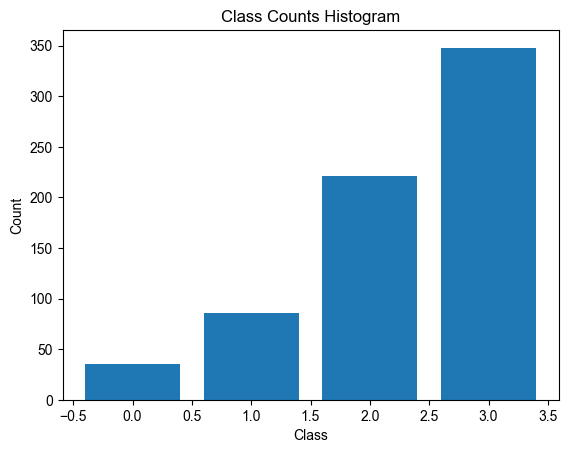

In [14]:
# enter your training dataframe: 

data = final_data.copy()

# enter the name of your response column: 

response = "sf_mp_average"

# enter the cutoff you want: 

cutoffs = {
    'cutoff_1': 50,
    'cutoff_2': 80,
    'cutoff_3': 150,  # Enter a new class if needed
    'cutoff_4': None,  # Enter a new class if needed
    'cutoff_5': None,  # Enter a new class if needed
}

################## no changes below here ######################

pattern = r'^x([1-9]\d{0,2}|1000)_'
properties_start = next((col for col in data.columns if re.match(pattern, col)), None)
properties_start_idx = data.columns.get_loc(properties_start)


X = data.iloc[:,properties_start_idx:].values
y = data[response]

## cutoffs:

cutoff_values = [value for value in cutoffs.values() if value is not None]
cutoff_values.sort()

# Create y_class based on the sorted cutoffs
y_class = []
for i in y:
    for idx, cutoff in enumerate(cutoff_values):
        if i < cutoff:
            y_class.append(idx)
            break
    else:
        # If the value doesn't match any cutoff, assign it to the last class
        y_class.append(len(cutoff_values))

y_class = np.array(y_class)
y_class = y_class.astype(int)
X_labelname = data.columns[properties_start_idx:].tolist()


class_counts = np.bincount(y_class)

# Print the number of values in each class
for class_num, count in enumerate(class_counts):
    print(f"Class {class_num}: {count} values")

    
###
max_count = np.max(class_counts)
ratios = {i: int(round(max_count / count)) for i, count in enumerate(class_counts)}
print(f"Recomended class weights: {ratios}")


# Plot the class counts as a histogram
plt.bar(range(len(class_counts)), class_counts)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Counts Histogram")
plt.show()

### GRID SEARCH

In [15]:
test_size = 0.30
kfold_splits = 5

X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=test_size, shuffle=True, random_state=random_state)

kfold = KFold(n_splits=kfold_splits, shuffle=True, random_state=random_state)
param_grid = {'criterion': ['gini','entropy'],
              'class_weight': [{0: 10, 1: 4, 2: 2, 3: 1},
                               {0: 20, 1: 5, 2: 2, 3: 1}
                              ],
             'max_depth': [2,3,4]}

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=kfold, return_train_score=True)
grid_search.fit(X_train, y_train)

print("Best hyperparameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

results_grid = pd.DataFrame(grid_search.cv_results_)

Best parameters: {'class_weight': {0: 10, 1: 4, 2: 2, 3: 1}, 'criterion': 'gini', 'max_depth': 2}
Best cross-validation score: 0.52


### FINAL DT

/Users/lucaskaras/opt/miniconda3/envs/ullmann_project/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.56
Precision: 0.63
Recall: 0.51
F1 Score: 0.39


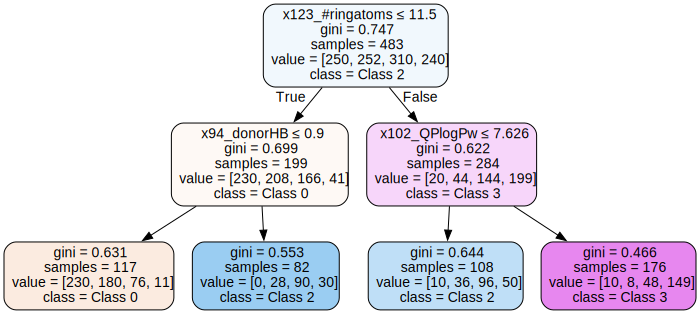

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.30, shuffle=True, random_state=random_state)

class_weight={0: 10, 1: 4, 2: 2, 3: 1}

model_final = DecisionTreeClassifier(random_state=random_state,
                               max_depth=2,
                               criterion='gini',
                               min_samples_split=3,
                               min_samples_leaf=3,
                               max_features=None,
                               class_weight=class_weight 
                              )

#####################################
model_final.fit(X_train, y_train)
y_pred = model_final.predict(X_test)

#####################################
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred,average='weighted')
recall = recall_score(y_test, y_pred,average='macro')
f1 = f1_score(y_test, y_pred,average='macro')

print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))
#####################################
class_names = [f'Class {class_num}' for class_num, count in enumerate(class_counts)]
dot_data = export_graphviz(model_final, out_file=None,
                           feature_names=X_labelname,
                           class_names = class_names,
                           filled=True, rounded=True,
                           special_characters=True)

graph = graphviz.Source(dot_data)
graph

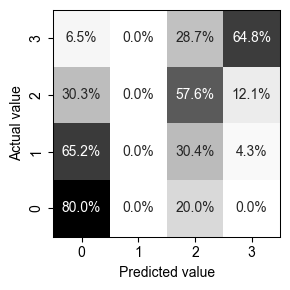

In [17]:
#####################################
fig, ax = plt.subplots(figsize=(3,3))
cm = confusion_matrix(y_test, y_pred, normalize='true')
cm = np.flipud(cm)

yticklabels = ([f'{class_num}' for class_num, count in enumerate(class_counts)])
xticklabels = ([f'{class_num}' for class_num, count in enumerate(class_counts)])
res = sns.heatmap(cm, annot=True, cmap='Greys', fmt='.1%',cbar=False, yticklabels=yticklabels[::-1], xticklabels=xticklabels)
for _, spine in res.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(0.75)
    
ax.set_xlabel('Predicted value')
ax.set_ylabel('Actual value')
ax.set_xticks(np.arange(len(class_counts)) + 0.5)
ax.set_yticks(np.arange(len(class_counts)) + 0.5)

fig.tight_layout()
# fig.savefig("cm.png", dpi=600, bbox_inches='tight')
plt.show()
#####################################

Average cross-validation score: 0.51


,fit_time,score_time,test_score,train_score
0,0.010174,0.000716,0.543478,0.554348
1,0.010967,0.001059,0.572464,0.547101
2,0.010975,0.000851,0.442029,0.500000
3,0.010577,0.000925,0.463768,0.592391
4,0.012010,0.000869,0.536232,0.556159


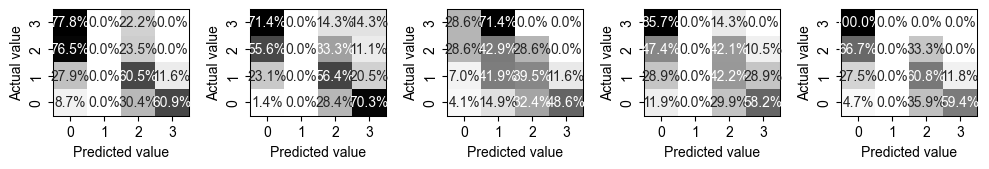

In [18]:
#####################################
kfold = KFold(n_splits=5, shuffle=True, random_state=random_state)
scores = cross_val_score(model_final, X, y_class, cv=kfold)
average_score = scores.mean()
scores_new = cross_validate(model_final, X, y_class, cv=kfold, return_train_score = True)
print("Average cross-validation score: {:.2f}".format(average_score))
display(pd.DataFrame(scores_new))
#####################################
confusion_matrices = []
# Perform k-fold cross-validation
for train_idx, test_idx in kfold.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y_class[train_idx], y_class[test_idx]

    # Train your model on the training data
    model_final.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model_final.predict(X_test)

    # Calculate the confusion matrix for this fold
    cm = confusion_matrix(y_test, y_pred, normalize='true')

    # Append the confusion matrix to the list
    confusion_matrices.append(cm)
#####################################
# Create a figure with subplots in a single row
fig, axes = plt.subplots(1, len(confusion_matrices), figsize=(2 * len(confusion_matrices), 1.8))
yticklabels = ([f'{class_num}' for class_num, count in enumerate(class_counts)])
xticklabels = ([f'{class_num}' for class_num, count in enumerate(class_counts)])
# Enumerate over the confusion matrices and plot them in the subplots
for i, cm in enumerate(confusion_matrices):
    ax = axes[i]
    res = sns.heatmap(cm, annot=True, cmap='Greys', fmt='.1%', cbar=False, yticklabels=yticklabels[::-1], xticklabels=xticklabels, ax=ax)
    for _, spine in res.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.75)

    ax.set_xlabel('Predicted value')
    ax.set_ylabel('Actual value')
    ax.set_xticks(np.arange(len(class_counts)) + 0.5)
    ax.set_yticks(np.arange(len(class_counts)) + 0.5)

fig.tight_layout()
plt.show()

### EXPORT DT

In [ ]:
#### NEED TO MAKE A NEW DF WITH THREE FEATURES ONLY

# filename = 'dt_model.pkl'
# with open(filename, 'wb') as file:
#     pickle.dump(model_final, file)